In [1]:
#import ReadRawMHD as rR
import mapping_noRot as mappNR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import SimpleITK as sitk
import time
import os
t1 = time.time()

In [2]:
# # # # # Input # # # # #
# Input imaging data
# FE version
models = ['00_L50_S50_D30', '01_L50_S50_D35', '02_L50_S50_D40', '03_L50_S50_D45', '04_L50_S50_D27',  # 0, 1, 2, 3, 4
          '10_L50_S00_D30', '11_L50_S00_D35', '12_L50_S00_D40', '13_L50_S00_D45', '14_L50_S00_D27', '15_L50_S00_D44',
          '31_L50_S50_D35', '43_L50_S00_D45',  # 11, 12
          '50_L50_S00_D30', '55_L50_S00_D30',  # 13, 14
          '63_L50_S50_D45', '74_L50_S50_D45', '75_L50_S50_D45',  '76_L50_S50_D45', '77_L50_S50_D45',  # 15, 16, 17, 18, 19
          '80_L50_S50_D45', '83_L50_S50_D45']  # 20, 21


model_code = models[20]  # FEA model name
print('Model: ' + str(model_code))
sample_code = 'S131318_L1_left'  # Experimental sample. contains number and sample name
# ExpScrew no use anymore.
#ExpScrew = 'P'  # T or P, site from experiment. Two input files (SimScrew Ti and PEEK) will always be generated

Model: 80_L50_S50_D45


In [3]:
# Specify file locations
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample_code + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/98_Pilots/' + sample_code + '/' + model_code + '/'  # Folder of FEA files
file_bone = [filename for filename in os.listdir(path_ct + '/') if filename.endswith('image.mhd') and str(sample_code) in filename][0]
print(file_bone)

S131318_L1_left_screw_image.mhd


In [4]:
# # # # # Input # # # # #
# Input FEA data
Input = {}
Input['Project_Folder'] = path_project
Input['FEA_loc'] = path_fea  # path to FEA files
Input['Model_Code'] = model_code  # model code (FEA model name)
#Input['Screw'] = ExpScrew  # which site of scan will be processed
Input['Resolution'] = 0.0606995  # scan resolution, should be 0.0606995 for HR-pQCT II

Input['Load_mode'] = 'd'  # no effect 'd' or 'f', displacement or force controlled
## ********* EXCLUDED (line 357 in mapping.py)

Input['d_dir'] = '-'  # displ direction (negative corresponds to experiment, positive = inverse). Input: '-' or '+'
Input['d_max'] = 1  # peak displ

Input['Friction'] = 0.2  # friction between screw and bone
Input['Mapping_Diameter'] = 2  # diameter of sphere for mapping, in mm. should be larger than element size

# Check if folder exists, otherwise create it
isExist = os.path.exists(Input['FEA_loc'])
if not isExist:
    os.makedirs(Input['FEA_loc'])
    print('New directory created: ' + Input['FEA_loc'])

# Submit on cortex or ubelix?
# -> Other parameters as e-mail, runtime, memory etc. can be changed in the template file
Input['Submit'] = 'ubelix'
mappNR.write_submit(Input)

# Take screw axis or points from PMMA area
screw_axis = 1

# Write output images? segmented image and mask, for visual check
write_output = 1

New directory created: /home/biomech/Documents/01_Icotec/02_FEA/98_Pilots/S131318_L1_left/80_L50_S50_D45/


In [5]:
# Write mesh input file
mappNR.write_mesh(Input)  # Original input file, path for mesh.inp


Finished extracting mesh file.


In [6]:
bone = {}
bone = mappNR.readInpBoneDummy(bone, Input)  # Read bone mesh from abaqus. Read elements, nodes
bone = mappNR.load_BVTVdata(bone, path_ct + file_bone)
bone = mappNR.boneMeshMask(bone, Input)  # Create mask from abaqus bone mesh

BoneMeshMask


insBefore: [218 388 121]
insAfter: [ 94 125 283]
mask dimension: [190 289 824]
bone dimension: [ 502  802 1228]
new mask dimension: [ 502  802 1228]


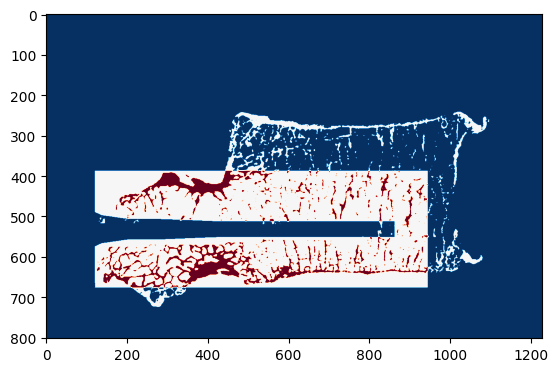

In [12]:
# Read mask
imMask = sitk.ReadImage(Input['FEA_loc'] + Input['Model_Code'] + '_mask.mhd')
imMask_np = np.transpose(sitk.GetArrayFromImage(imMask), [2, 1, 0])
orM = np.array(imMask.GetOrigin())
orB = np.array(bone['GreyImage'].GetOrigin())
insBefore = np.rint(abs(orB-orM)/Input['Resolution']).astype(int)
bone['insBefore'] = insBefore
print('insBefore: ' + str(insBefore))
dimMask = np.array(imMask.GetSize())
dimBone = np.array(bone['GreyImage'].GetSize())
insAfter = (dimBone-dimMask-insBefore).astype(int)
bone['insAfter'] = insAfter
print('insAfter: ' + str(insAfter))
print('mask dimension: ' + str(dimMask))
print('bone dimension: ' + str(dimBone))
imMask_np_corr = imMask_np
#print(np.zeros((insBefore[0], dimMask[1], dimMask[2])))
imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[0], imMask_np_corr.shape[1], imMask_np_corr.shape[2])), 0), np.zeros((insAfter[0], imMask_np_corr.shape[1], imMask_np_corr.shape[2])), 0)
#print('current mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[1], imMask_np_corr.shape[0], imMask_np_corr.shape[2])), 1), np.zeros((imMask_np_corr.shape[0], insAfter[1], imMask_np_corr.shape[2])), 1)
#print('current mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imMask_np_corr = np.append(np.insert(imMask_np_corr, 0, np.zeros((insBefore[2], imMask_np_corr.shape[0], imMask_np_corr.shape[1])), 2), np.zeros((imMask_np_corr.shape[0], imMask_np_corr.shape[1], insAfter[2])), 2)
print('new mask dimension: ' + str(np.array(imMask_np_corr.shape)))

imSum = imMask_np_corr + bone['BVTVscaled']
plt.figure()
plt.imshow(imSum[insBefore[0]+int(dimMask[0]/2), :, :], cmap=cm.RdBu_r)

In [8]:
bone['MASK'] = imMask_np_corr
if write_output:
    img_seg=sitk.GetImageFromArray(np.transpose(bone['BVTVscaled'], [2, 1, 0]))
    img_seg.SetOrigin(bone['GreyImage'].GetOrigin())
    img_seg.SetSpacing(bone['GreyImage'].GetSpacing())
    sitk.WriteImage(img_seg, path_fea + sample_code + '_seg.mhd')
    print('Segmented image saved.')
del img_seg
# del bone['GreyImage']

Segmented image saved.


In [9]:
mappNR.HFE_mapping_trans(bone, Input)

... start material mapping with copying boundary layers as ghost layers
... material mapping element 3000/4388

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'elems': {1: <MedtoolFunctions.med_classes.element at 0x7f08a530f760>,
  2: <MedtoolFunctions.med_classes.element at 0x7f08a530f790>,
  3: <MedtoolFunctions.med_classes.element at 0x7f08a530f7c0>,
  4: <MedtoolFunctions.med_classes.element at 0x7f08a530f7f0>,
  5: <MedtoolFunctions.med_classes.element at 0x7f08a530f820>,
  6: <MedtoolFunctions.med_classes.element at 0x7f08a530f850>,
  7: <MedtoolFunctions.med_classes.element at 0x7f08a530f880>,
  8: <MedtoolFunctions.med_classes.element at 0x7f08a530f8b0>,
  9: <MedtoolFunctions.med_classes.element at 0x7f08a530f8e0>,
  10: <MedtoolFunctions.med_classes.element at 0x7f08a530f910>,
  11: <MedtoolFunctions.med_classes.element at 0x7f08a530f940>,
  12: <MedtoolFunctions.med_classes.element at 0x7f08a530f970>,
  13: <MedtoolFunctions.med_classes.element at 0x7f08a530f9a0>,
  14: <MedtoolFunctions.med_classes.element at 0x7f08a530f9d0>,
  15: <MedtoolFunctions.med_classes.element at 0x7f08a530fa00>,
  16: <MedtoolFunctions.med_classes.elem

In [10]:
# Write final input file
mappNR.HFE_inp_creator(Input)
if not write_output:
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + '_elsets.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + '_materials.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + '_mesh.inp')
    os.remove(path_fea + model_code + '_mask.mhd')
    os.remove(path_fea + model_code + '_mask.raw')

Section set to Ti.
Section set to PEEK.
End HFE_inp_creator


In [11]:
tRun = time.time()-t1
if tRun >= 3600:
    print('Execution time: ' + str(int(tRun/3600)) + ' h ' + str(int(np.mod(tRun, 3600)/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
elif tRun >= 60:
    print('Execution time: ' + str(int(tRun/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
else:
    print('Execution time: ' + str(round(tRun, 1)) + ' sec.')

Execution time: 3 min 29.7 sec.
